In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d /content/brain_mri_images
!kaggle datasets download -d andrewmvd/heart-failure-clinical-data
!unzip heart-failure-clinical-data.zip -d /content/heart_failure_data

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace /content/brain_mri_images/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/brain_mri_images/brain_tumor_dataset/no/14 no.jpg  
 

Tabular Dataset Preview:
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     

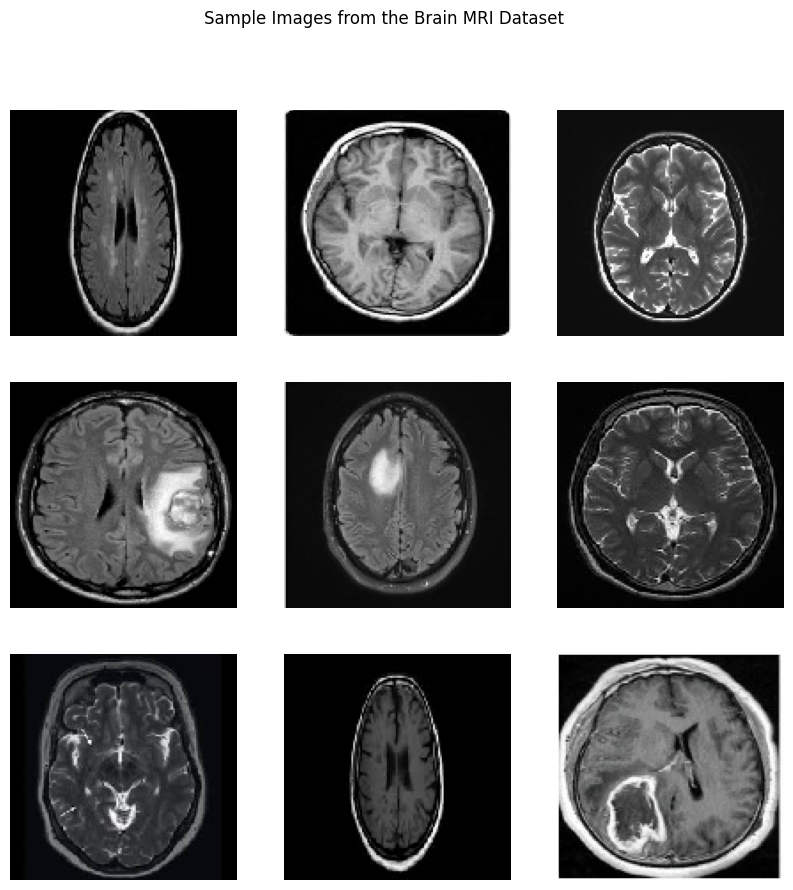

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

!pip install --upgrade umap-learn


import plotly.express as px
from sklearn.manifold import TSNE, Isomap
from umap import UMAP
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA, FactorAnalysis

from sklearn.cluster import AgglomerativeClustering


tabular_path = '/content/heart_failure_data/heart_failure_clinical_records_dataset.csv'
tabular_data = pd.read_csv(tabular_path)

print("Tabular Dataset Preview:")
print(tabular_data.head())

image_dataset_path = '/content/brain_mri_images'
image_data_generator = ImageDataGenerator(rescale=1.0/255.0)
batch_size = 32
target_size = (128, 128)

if not os.path.exists(image_dataset_path):
    print(f"Error: Image dataset not found at {image_dataset_path}")

# Prepare image dataset
image_data = image_data_generator.flow_from_directory(
    image_dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True
)

# Step 3: Preprocess Datasets

if tabular_data.isnull().sum().sum() > 0:
    tabular_data.dropna(inplace=True)

scaler = StandardScaler()
tabular_data_scaled = scaler.fit_transform(tabular_data.iloc[:, :-1])  # Exclude target column if present

print(f"Tabular Dataset Shape: {tabular_data.shape}")
print(f"Image Dataset Shape: {image_data.n} images of size {target_size}")

np.save("tabular_data_scaled.npy", tabular_data_scaled)

plt.figure(figsize=(10, 10))

batch = next(image_data)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis('off')

plt.suptitle("Sample Images from the Brain MRI Dataset")
plt.show()


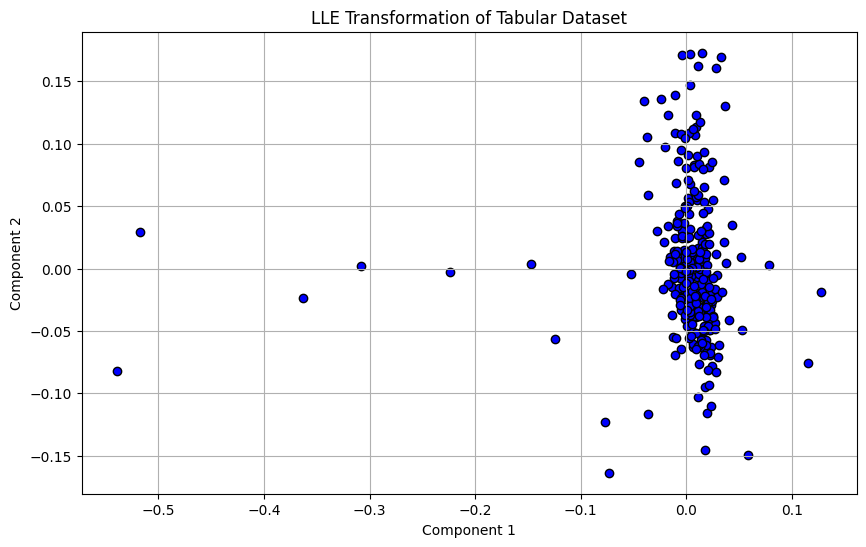

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

# Apply LLE to Tabular Dataset
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, random_state=42)
lle_transformed = lle.fit_transform(tabular_data_scaled)

# Visualize LLE results
plt.figure(figsize=(10, 6))
plt.scatter(lle_transformed[:, 0], lle_transformed[:, 1], c='blue', edgecolor='k')
plt.title("LLE Transformation of Tabular Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [18]:
from sklearn.manifold import TSNE
import plotly.express as px

# Apply t-SNE to Tabular Dataset
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_transformed = tsne.fit_transform(tabular_data_scaled)

tsne_df = pd.DataFrame(tsne_transformed, columns=['Component 1', 'Component 2'])

fig = px.scatter(tsne_df, x='Component 1', y='Component 2',
                 title="t-SNE Visualization of Tabular Data",
                 labels={'Component 1': 't-SNE Component 1', 'Component 2': 't-SNE Component 2'})
fig.show()
image_batch = next(image_data)  # Get a batch of images
image_batch_flat = image_batch.reshape(image_batch.shape[0], -1)  # Flatten each image

tsne_images = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_images_transformed = tsne_images.fit_transform(image_batch_flat)

tsne_images_df = pd.DataFrame(tsne_images_transformed, columns=['Component 1', 'Component 2'])

fig = px.scatter(tsne_images_df, x='Component 1', y='Component 2',
                 title="t-SNE Visualization of Image Data",
                 labels={'Component 1': 't-SNE Component 1', 'Component 2': 't-SNE Component 2'})
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



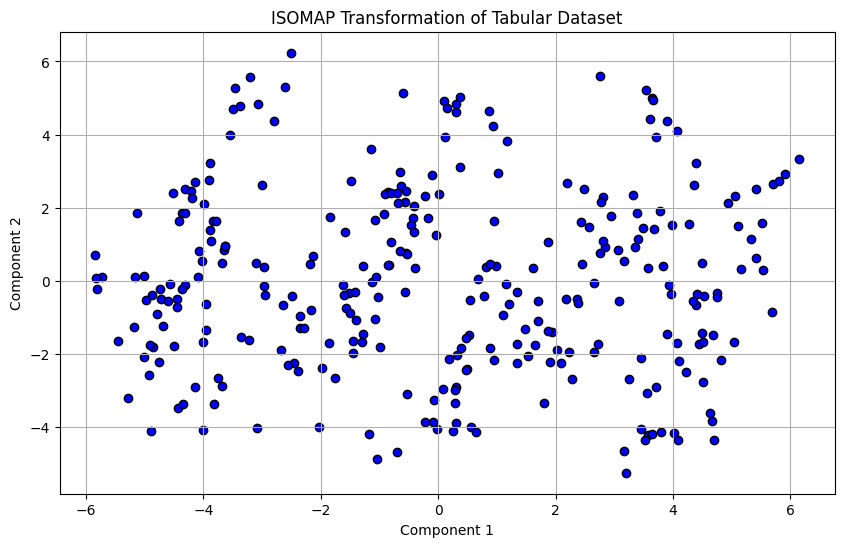

In [19]:
from sklearn.manifold import Isomap

# Apply ISOMAP to Tabular Dataset
isomap = Isomap(n_neighbors=10, n_components=2)
isomap_transformed = isomap.fit_transform(tabular_data_scaled)

# Visualize ISOMAP results
plt.figure(figsize=(10, 6))
plt.scatter(isomap_transformed[:, 0], isomap_transformed[:, 1], c='blue', edgecolor='k')
plt.title("ISOMAP Transformation of Tabular Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


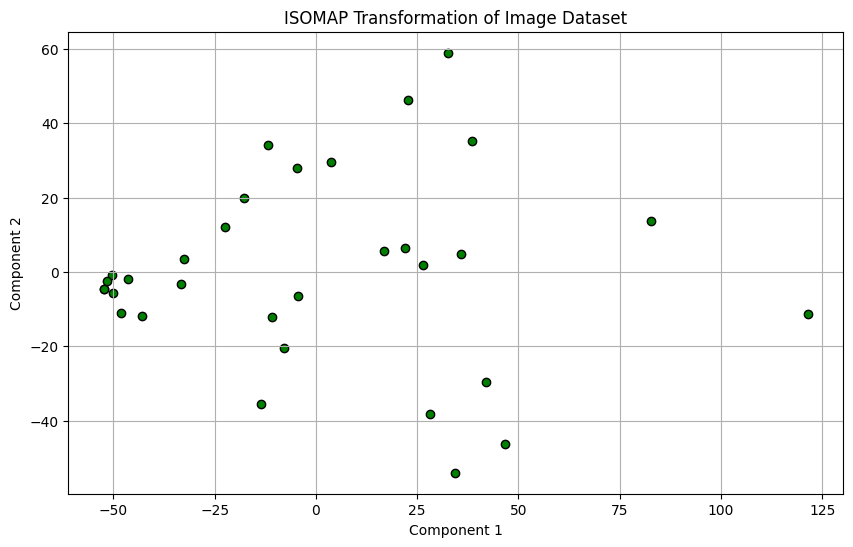

In [20]:
image_batch = next(image_data)
image_batch_flat = image_batch.reshape(image_batch.shape[0], -1)

# Apply ISOMAP to Image Dataset
isomap_images = Isomap(n_neighbors=10, n_components=2)
isomap_images_transformed = isomap_images.fit_transform(image_batch_flat)

# Visualize ISOMAP results for Image Data
plt.figure(figsize=(10, 6))
plt.scatter(isomap_images_transformed[:, 0], isomap_images_transformed[:, 1], c='green', edgecolor='k')
plt.title("ISOMAP Transformation of Image Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [21]:
from umap import UMAP

# Apply UMAP to Tabular Dataset
umap = UMAP(n_neighbors=15, n_components=2, random_state=42)
umap_transformed = umap.fit_transform(tabular_data_scaled)

umap_df = pd.DataFrame(umap_transformed, columns=['Component 1', 'Component 2'])

fig = px.scatter(umap_df, x='Component 1', y='Component 2',
                 title="UMAP Visualization of Tabular Data",
                 labels={'Component 1': 'UMAP Component 1', 'Component 2': 'UMAP Component 2'})
fig.show()
image_batch = next(image_data)
image_batch_flat = image_batch.reshape(image_batch.shape[0], -1)

# Apply UMAP to Image Dataset
umap_images = UMAP(n_neighbors=15, n_components=2, random_state=42)
umap_images_transformed = umap_images.fit_transform(image_batch_flat)

umap_images_df = pd.DataFrame(umap_images_transformed, columns=['Component 1', 'Component 2'])

fig = px.scatter(umap_images_df, x='Component 1', y='Component 2',
                 title="UMAP Visualization of Image Data",
                 labels={'Component 1': 'UMAP Component 1', 'Component 2': 'UMAP Component 2'})
fig.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



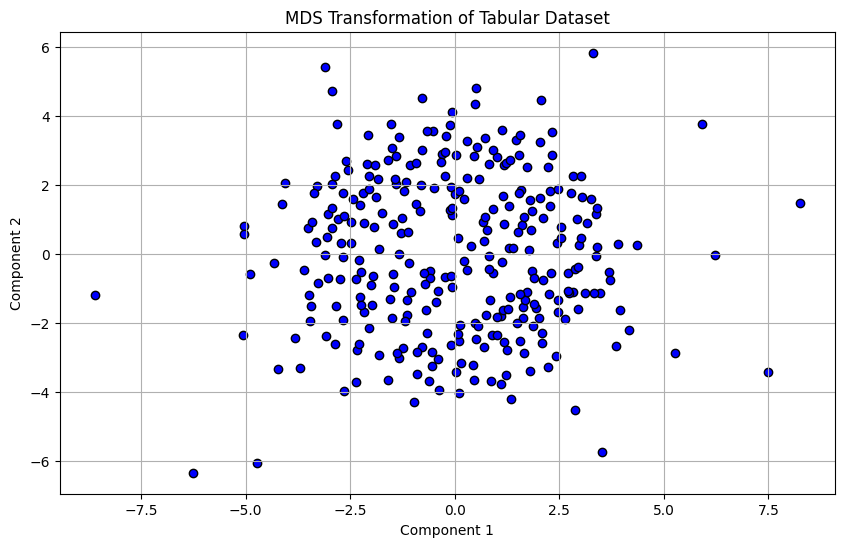

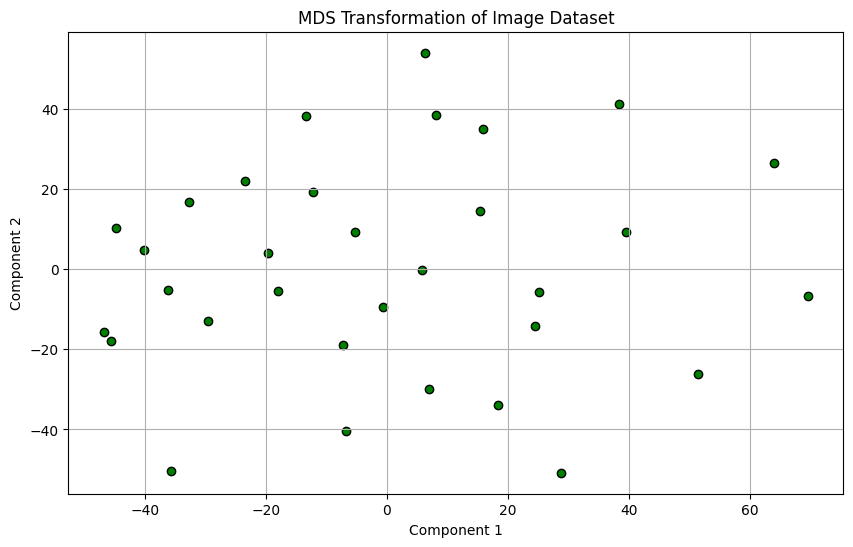

In [22]:
from sklearn.manifold import MDS

# Apply MDS to Tabular Dataset
mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(tabular_data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c='blue', edgecolor='k')
plt.title("MDS Transformation of Tabular Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

image_batch = next(image_data)
image_batch_flat = image_batch.reshape(image_batch.shape[0], -1)

mds_images = MDS(n_components=2, random_state=42)
mds_images_transformed = mds_images.fit_transform(image_batch_flat)

plt.figure(figsize=(10, 6))
plt.scatter(mds_images_transformed[:, 0], mds_images_transformed[:, 1], c='green', edgecolor='k')
plt.title("MDS Transformation of Image Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


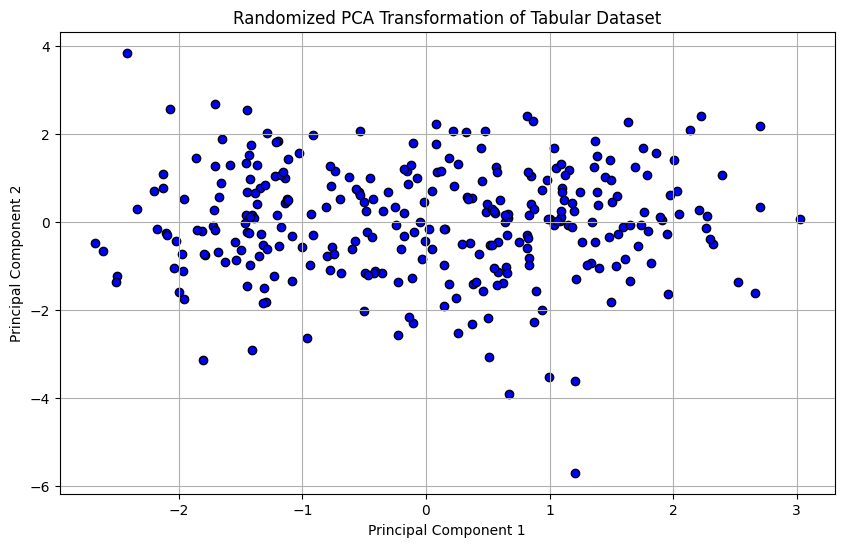

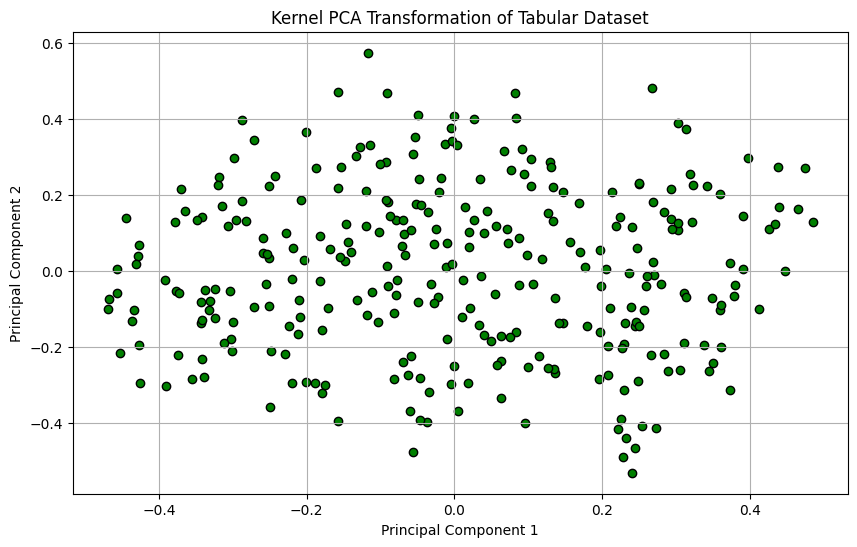

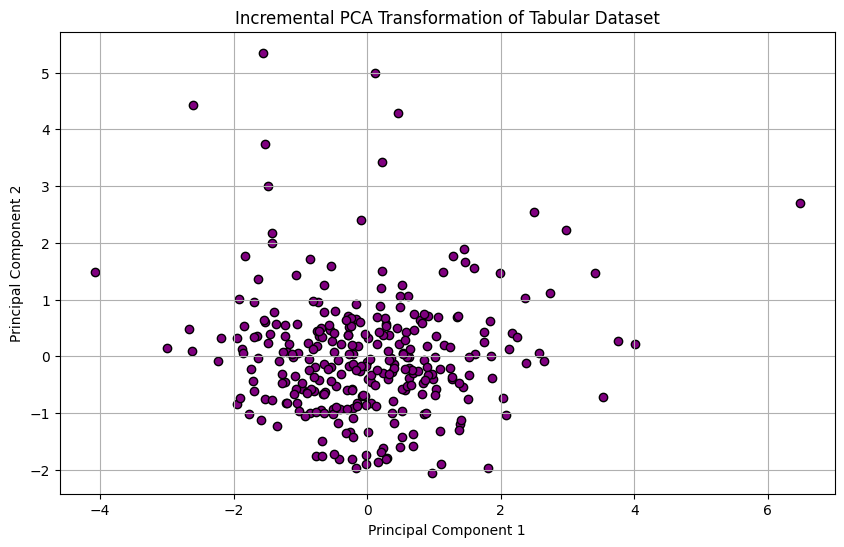

In [23]:
from sklearn.decomposition import PCA

randomized_pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
randomized_pca_transformed = randomized_pca.fit_transform(tabular_data_scaled)

# Visualize Randomized PCA results
plt.figure(figsize=(10, 6))
plt.scatter(randomized_pca_transformed[:, 0], randomized_pca_transformed[:, 1], c='blue', edgecolor='k')
plt.title("Randomized PCA Transformation of Tabular Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
from sklearn.decomposition import KernelPCA

# Apply Kernel PCA to Tabular Dataset
kernel_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04, random_state=42)
kernel_pca_transformed = kernel_pca.fit_transform(tabular_data_scaled)

# Visualize Kernel PCA results
plt.figure(figsize=(10, 6))
plt.scatter(kernel_pca_transformed[:, 0], kernel_pca_transformed[:, 1], c='green', edgecolor='k')
plt.title("Kernel PCA Transformation of Tabular Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
from sklearn.decomposition import IncrementalPCA

incremental_pca = IncrementalPCA(n_components=2)
incremental_pca_transformed = incremental_pca.fit_transform(tabular_data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(incremental_pca_transformed[:, 0], incremental_pca_transformed[:, 1], c='purple', edgecolor='k')
plt.title("Incremental PCA Transformation of Tabular Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


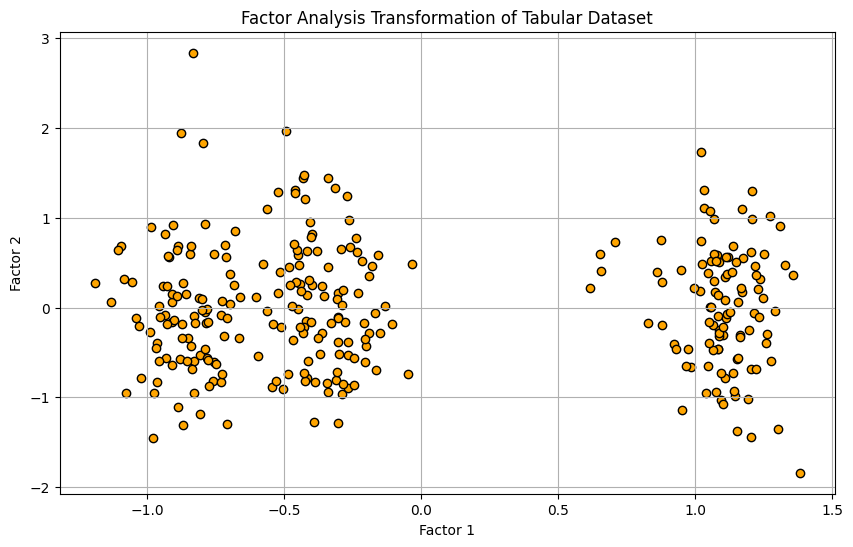

In [24]:
from sklearn.decomposition import FactorAnalysis

# Apply Factor Analysis to Tabular Dataset
factor_analysis = FactorAnalysis(n_components=2, random_state=42)
factor_analysis_transformed = factor_analysis.fit_transform(tabular_data_scaled)

# Visualize Factor Analysis results
plt.figure(figsize=(10, 6))
plt.scatter(factor_analysis_transformed[:, 0], factor_analysis_transformed[:, 1], c='orange', edgecolor='k')
plt.title("Factor Analysis Transformation of Tabular Dataset")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.grid(True)
plt.show()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1216
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1212
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1169
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1022
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0791
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0620
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0564
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0546
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0539
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0529
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


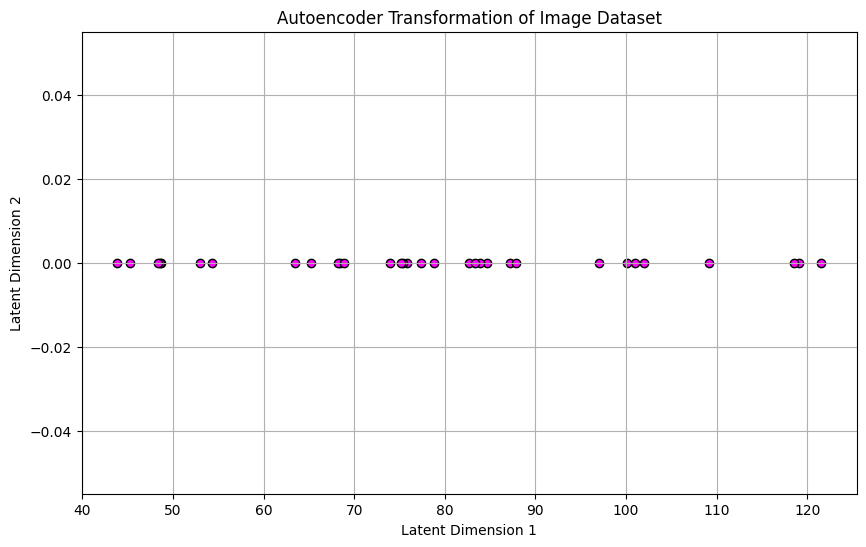

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

# Define Autoencoder Architecture
input_dim = image_batch_flat.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(image_batch_flat, image_batch_flat, epochs=10, batch_size=32, shuffle=True, verbose=1)

encoder = Model(input_layer, encoded)

autoencoder_transformed = encoder.predict(image_batch_flat)

plt.figure(figsize=(10, 6))
plt.scatter(autoencoder_transformed[:, 0], autoencoder_transformed[:, 1], c='magenta', edgecolor='k')
plt.title("Autoencoder Transformation of Image Dataset")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()
